# Data Collection
First, collecting data from https://en.wikipedia.org/wiki/List_of_active_nationalist_parties_in_Europe and parse the table.

In [20]:
import json
import requests


def get_wiki_page (title):
    wiki_endpoint = 'https://en.wikipedia.org/w/api.php'
    payload = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'revisions',
        'rvprop': 'content',
        'utf8': 'true'
    }
    request = requests.get(wiki_endpoint, params = payload)
    print 'GET ', request.url
    return json.loads(request.text)



In [19]:
# wikitables from https://github.com/bcicen/wikitables is used to 
# quickly and easily get the contents of the tables on the page

list_name = 'List of active nationalist parties in Europe'

from wikitables import import_tables
tables = import_tables(list_name)
parties = tables[0].rows
print 'Keys for every party'
for key in parties[0].keys():
    print ' - ', key
print tables[0].name 
for row in parties:
    print ' - ', row['Country'], ':', row['Party']

Keys for every party
 -  Votes
 -  % of popular vote
 -  Europarty
 -  Country
 -  Ideology, description
 -  Seats
 -  Party
 -  Date established
List of active nationalist parties in Europe[0]
 -  Armenia : Republican Party of Armenia
 -  Hungary : Fidesz
 -  Macedonia : VMRO-DPMNE
 -  Poland : Law and Justice
 -  Switzerland : Swiss People's Party
 -  Austria : Freedom Party of Austria
 -  Denmark : Danish People's Party
 -  Belgium : New Flemish Alliance
 -  Hungary : Jobbik
 -  Finland : Finns Party
 -  Italy : Lega Nord
 -  Latvia : National Alliance
 -  Norway : Progress Party
 -  Ireland : Sinn Féin
 -  France : National Front
 -  Netherlands : Party for Freedom
 -  Netherlands : Forum for Democracy
 -  Sweden : Sweden Democrats
 -  Germany : Alternative for Germany
 -  Russia : LDPR
 -  Norway : Centre Party
 -  Slovakia : Slovak National Party
 -  Estonia : Conservative People's Party of Estonia
 -  Serbia : Serbian Radical Party
 -  Slovakia : Kotleba - People’s Party Our Slo

Now that we have the contents of the table containing all the listed parties and some basic stats about them (country, number of votes etc.), we can go into the page for every party and fetch the contents. From this we'll try to parse out any non-trivial links (navigation and headers and so on) and try to build a network out of these.

In [89]:
import re

blacklist = [
    'Category',
    'list',
    'file:',
    'wiktionary:'
]

def processLink(link):
    decoded = link.encode('utf-8')
    split = re.split(r'[(|]+', decoded)
    return split[0]

def checkLink(link):
    return any(substring.lower() in link.lower() for substring in blacklist)

def getWikiLinks(text):
    pattern = r'\[\[(.*?)\]\]'
    links = re.findall(pattern, text)
    processed = [processLink(link) for link in links]
    return [link for link in processed if not checkLink(link)]

def clean_name(name):
    for ch in [' ', '-']:
        name = name.replace(ch, '_')
    for ch in [",", ".",'–']:
        name = name.replace(ch, '')
    return name.lower().decode('utf-8')

for i, party in enumerate(parties):
    party = dict(party)
    party_name = str(party['Party'])
    party_title = clean_name(party_name)
    party['title'] = party_title
    print 'Party name:', party_name
    pages_json = get_wiki_page(party_name)
    pages = pages_json['query']['pages']
    for key in pages.keys():
        try:
            text = pages[key]['revisions'][0]['*']
            party['links'] = list(set(getWikiLinks(text)))
            print 'Found', len(party['links']), 'links'
        except:
            print '--------- Failed to fetch text for', party_name
            party['links'] = []
            continue
    parties[i] = party    


Party name: Republican Party of Armenia
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Republican+Party+of+Armenia&action=query
Found 59 links
Party name: Fidesz
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Fidesz&action=query
Found 97 links
Party name: VMRO-DPMNE
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=VMRO-DPMNE&action=query
Found 70 links
Party name: Law and Justice
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Law+and+Justice&action=query
Found 151 links
Party name: Swiss People's Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Swiss+People%27s+Party&action=query
Found 137 links
Party name: Freedom Party of Austria
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=National+Democratic+Party&action=query
Found 18 links
Party name: Greater Romania Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Greater+Romania+Party&action=query
Found 72 links
Party name: Workers' Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Workers%27+Party&action=query
Found 114 links
Party name: Lithuanian Nationalist Union
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Lithuanian+Nationalist+Union&action=query
Found 35 links
Party name: Young Lithuania
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Young+Lithuania&action=query
Found 13 links
Party name: National Renovator Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revis

In [110]:
import networkx as nx

graph = nx.MultiGraph()

for party in parties:
    graph.add_node(party['title'], **dict(party))
    
for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        if graph.has_node(clean_link):
            print 'Adding edge level 1', clean_link, party['title']
            graph.add_edge(clean_link, party['title'], level='1')
        for j, party2 in enumerate(parties):
            if i != j:
                links2 = party2['links']
                for link2 in links2:
                    if link == link2 and not graph.has_edge(party2['title'], party['title'], key='level'):
                        print graph.has_edge(party2['title'], party['title'], key='level')
                        print 'Adding edge level 2', link, party2['title'], party['title']
                        graph.add_edge(party2['title'], party['title'], level='2', link=link)

False
Adding edge level 2 Armenian parliamentary election, 1995 armenian_revolutionary_federation republican_party_of_armenia
False
Adding edge level 2 National conservatism fidesz republican_party_of_armenia
False
Adding edge level 2 National conservatism vmro_dpmne republican_party_of_armenia
False
Adding edge level 2 National conservatism law_and_justice republican_party_of_armenia
False
Adding edge level 2 National conservatism swiss_people's_party republican_party_of_armenia
False
Adding edge level 2 National conservatism freedom_party_of_austria republican_party_of_armenia
False
Adding edge level 2 National conservatism danish_people's_party republican_party_of_armenia
False
Adding edge level 2 National conservatism jobbik republican_party_of_armenia
False
Adding edge level 2 National conservatism finns_party republican_party_of_armenia
False
Adding edge level 2 National conservatism sweden_democrats republican_party_of_armenia
False
Adding edge level 2 National conservatism alte

Adding edge level 2 European Parliament election, 2009  slovak_national_party fidesz
False
Adding edge level 2 European Parliament election, 2009  alternative_democratic_reform_party fidesz
False
Adding edge level 2 European Parliament election, 2009  order_and_justice fidesz
False
Adding edge level 2 European Parliament election, 2009  slovenian_national_party fidesz
False
Adding edge level 2 European Parliament election, 2009  national_renovator_party fidesz
False
Adding edge level 2 European Parliament election, 2009  tricolour_flame fidesz
False
Adding edge level 2 European Parliament election, 2009  self_defence_of_the_republic_of_poland fidesz
False
Adding edge level 2 European Parliament election, 2009  british_national_party fidesz
False
Adding edge level 2 Independent Smallholders, Agrarian Workers and Civic Party jobbik fidesz
False
Adding edge level 2 Council of Europe danish_people's_party fidesz
False
Adding edge level 2 Council of Europe armenian_revolutionary_federation 

Adding edge level 2 National conservatism alternative_democratic_reform_party vmro_dpmne
False
Adding edge level 2 National conservatism order_and_justice vmro_dpmne
False
Adding edge level 2 National conservatism croatian_party_of_rights vmro_dpmne
False
Adding edge level 2 National conservatism united_romania_party vmro_dpmne
False
Adding edge level 2 National conservatism croatian_pure_party_of_rights vmro_dpmne
False
Adding edge level 2 National conservatism greater_romania_party vmro_dpmne
False
Adding edge level 2 National conservatism lithuanian_nationalist_union vmro_dpmne
False
Adding edge level 2 National conservatism young_lithuania vmro_dpmne
False
Adding edge level 2 National conservatism national_renovator_party vmro_dpmne
False
Adding edge level 2 National conservatism albanian_national_front_party vmro_dpmne
False
Adding edge level 2 National conservatism national_democracy vmro_dpmne
False
Adding edge level 2 National conservatism conservative_party_of_georgia vmro_dpm

False
Adding edge level 2 European Parliament election, 2009  fidesz law_and_justice
False
Adding edge level 2 European Parliament election, 2009  freedom_party_of_austria law_and_justice
False
Adding edge level 2 European Parliament election, 2009  danish_people's_party law_and_justice
False
Adding edge level 2 European Parliament election, 2009  new_flemish_alliance law_and_justice
False
Adding edge level 2 European Parliament election, 2009  jobbik law_and_justice
False
Adding edge level 2 European Parliament election, 2009  finns_party law_and_justice
False
Adding edge level 2 European Parliament election, 2009  lega_nord law_and_justice
False
Adding edge level 2 European Parliament election, 2009  sinn_féin law_and_justice
False
Adding edge level 2 European Parliament election, 2009  party_for_freedom law_and_justice
False
Adding edge level 2 European Parliament election, 2009  sweden_democrats law_and_justice
False
Adding edge level 2 European Parliament election, 2009  slovak_na

Adding edge level 2 Polish parliamentary election, 2011 congress_of_the_new_right law_and_justice
False
Adding edge level 2 Polish parliamentary election, 2011 self_defence_of_the_republic_of_poland law_and_justice
False
Adding edge level 2 Centrism lega_nord law_and_justice
False
Adding edge level 2 Centrism party_for_freedom law_and_justice
False
Adding edge level 2 Centrism sweden_democrats law_and_justice
False
Adding edge level 2 Centrism centre_party law_and_justice
False
Adding edge level 2 Polish parliamentary election, 2015 congress_of_the_new_right law_and_justice
False
Adding edge level 2 Polish parliamentary election, 2015 self_defence_of_the_republic_of_poland law_and_justice
False
Adding edge level 2 Alliance of Conservatives and Reformists in Europe finns_party law_and_justice
False
Adding edge level 2 Alliance of Conservatives and Reformists in Europe alternative_democratic_reform_party law_and_justice
False
Adding edge level 2 Alliance of Conservatives and Reformists i

Adding edge level 2 Right-wing populism greater_romania_party swiss_people's_party
False
Adding edge level 2 Right-wing populism young_lithuania swiss_people's_party
False
Adding edge level 2 Right-wing populism national_renovator_party swiss_people's_party
False
Adding edge level 2 Right-wing populism moviment_patrijotti_maltin swiss_people's_party
False
Adding edge level 2 Right-wing populism congress_of_ukrainian_nationalists swiss_people's_party
False
Adding edge level 2 Right-wing populism españa_2000 swiss_people's_party
False
Adding edge level 2 Right-wing populism congress_of_the_new_right swiss_people's_party
False
Adding edge level 2 Right-wing populism british_national_party swiss_people's_party
False
Adding edge level 2 judiciary fidesz swiss_people's_party
False
Adding edge level 2 left-wing politics lega_nord swiss_people's_party
False
Adding edge level 2 left-wing politics party_for_freedom swiss_people's_party
False
Adding edge level 2 left-wing politics alternative_dem

Adding edge level 2 National conservatism jobbik swiss_people's_party
False
Adding edge level 2 National conservatism finns_party swiss_people's_party
False
Adding edge level 2 National conservatism sweden_democrats swiss_people's_party
False
Adding edge level 2 National conservatism alternative_for_germany swiss_people's_party
False
Adding edge level 2 National conservatism slovak_national_party swiss_people's_party
False
Adding edge level 2 National conservatism conservative_people's_party_of_estonia swiss_people's_party
False
Adding edge level 2 National conservatism national_front_for_the_salvation_of_bulgaria swiss_people's_party
False
Adding edge level 2 National conservatism imro__bulgarian_national_movement swiss_people's_party
False
Adding edge level 2 National conservatism alternative_democratic_reform_party swiss_people's_party
False
Adding edge level 2 National conservatism order_and_justice swiss_people's_party
False
Adding edge level 2 National conservatism croatian_party

Adding edge level 2 World War II jobbik swiss_people's_party
False
Adding edge level 2 World War II party_for_freedom swiss_people's_party
False
Adding edge level 2 World War II armenian_revolutionary_federation swiss_people's_party
False
Adding edge level 2 World War II slovenian_national_party swiss_people's_party
False
Adding edge level 2 World War II greater_romania_party swiss_people's_party
False
Adding edge level 2 World War II national_democracy swiss_people's_party
False
Adding edge level 2 Jean-Marie Le Pen sweden_democrats freedom_party_of_austria
False
Adding edge level 2 Jean-Marie Le Pen order_and_justice freedom_party_of_austria
False
Adding edge level 2 Jean-Marie Le Pen greater_romania_party freedom_party_of_austria
False
Adding edge level 2 Jean-Marie Le Pen british_national_party freedom_party_of_austria
False
Adding edge level 2 Marine Le Pen lega_nord freedom_party_of_austria
False
Adding edge level 2 Marine Le Pen party_for_freedom freedom_party_of_austria
False
A

Adding edge level 2 European Union british_national_party freedom_party_of_austria
False
Adding edge level 2 European Union britain_first freedom_party_of_austria
False
Adding edge level 2 blue collar finns_party freedom_party_of_austria
False
Adding edge level 2 direct democracy swiss_people's_party freedom_party_of_austria
False
Adding edge level 2 direct democracy alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 direct democracy conservative_people's_party_of_estonia freedom_party_of_austria
False
Adding edge level 2 Italian Social Movement lega_nord freedom_party_of_austria
False
Adding edge level 2 Italian Social Movement tricolour_flame freedom_party_of_austria
False
Adding edge level 2 The Independent jobbik freedom_party_of_austria
False
Adding edge level 2 The Independent lega_nord freedom_party_of_austria
False
Adding edge level 2 The Independent alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 The Independent britain_first 

False
Adding edge level 2 Euroscepticism swiss_people's_party freedom_party_of_austria
False
Adding edge level 2 Euroscepticism danish_people's_party freedom_party_of_austria
False
Adding edge level 2 Euroscepticism new_flemish_alliance freedom_party_of_austria
False
Adding edge level 2 Euroscepticism jobbik freedom_party_of_austria
False
Adding edge level 2 Euroscepticism finns_party freedom_party_of_austria
False
Adding edge level 2 Euroscepticism lega_nord freedom_party_of_austria
False
Adding edge level 2 Euroscepticism party_for_freedom freedom_party_of_austria
False
Adding edge level 2 Euroscepticism alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 Euroscepticism slovak_national_party freedom_party_of_austria
False
Adding edge level 2 Euroscepticism conservative_people's_party_of_estonia freedom_party_of_austria
False
Adding edge level 2 Euroscepticism national_front_for_the_salvation_of_bulgaria freedom_party_of_austria
False
Adding edge level 2 Eurosce

False
Adding edge level 2 European Parliament fidesz freedom_party_of_austria
False
Adding edge level 2 European Parliament law_and_justice freedom_party_of_austria
False
Adding edge level 2 European Parliament danish_people's_party freedom_party_of_austria
False
Adding edge level 2 European Parliament new_flemish_alliance freedom_party_of_austria
False
Adding edge level 2 European Parliament jobbik freedom_party_of_austria
False
Adding edge level 2 European Parliament finns_party freedom_party_of_austria
False
Adding edge level 2 European Parliament lega_nord freedom_party_of_austria
False
Adding edge level 2 European Parliament sinn_féin freedom_party_of_austria
False
Adding edge level 2 European Parliament party_for_freedom freedom_party_of_austria
False
Adding edge level 2 European Parliament sweden_democrats freedom_party_of_austria
False
Adding edge level 2 European Parliament slovak_national_party freedom_party_of_austria
False
Adding edge level 2 European Parliament conservativ

Adding edge level 2 UK Independence Party alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 UK Independence Party conservative_people's_party_of_estonia freedom_party_of_austria
False
Adding edge level 2 UK Independence Party united_kingdom_independence_party freedom_party_of_austria
False
Adding edge level 2 UK Independence Party british_national_party freedom_party_of_austria
False
Adding edge level 2 UK Independence Party britain_first freedom_party_of_austria
False
Adding edge level 2 Frankfurter Allgemeine Zeitung alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 The Washington Post swiss_people's_party freedom_party_of_austria
False
Adding edge level 2 The Washington Post alternative_for_germany freedom_party_of_austria
False
Adding edge level 2 The Washington Post right_sector freedom_party_of_austria
False
Adding edge level 2 The Washington Post britain_first freedom_party_of_austria
False
Adding edge level 2 Die Welt swiss_peop

Adding edge level 2 Right-wing populism young_lithuania danish_people's_party
False
Adding edge level 2 Right-wing populism national_renovator_party danish_people's_party
False
Adding edge level 2 Right-wing populism moviment_patrijotti_maltin danish_people's_party
False
Adding edge level 2 Right-wing populism congress_of_ukrainian_nationalists danish_people's_party
False
Adding edge level 2 Right-wing populism españa_2000 danish_people's_party
False
Adding edge level 2 Right-wing populism congress_of_the_new_right danish_people's_party
False
Adding edge level 2 Right-wing populism british_national_party danish_people's_party
False
Adding edge level 2 United Nations High Commissioner for Refugees lega_nord danish_people's_party
False
Adding edge level 2 United Nations High Commissioner for Refugees sweden_democrats danish_people's_party
False
Adding edge level 2 Conservative Party  finns_party danish_people's_party
False
Adding edge level 2 Conservative Party  lega_nord danish_people's

False
Adding edge level 2 Right-wing politics fidesz danish_people's_party
False
Adding edge level 2 Right-wing politics vmro_dpmne danish_people's_party
False
Adding edge level 2 Right-wing politics law_and_justice danish_people's_party
False
Adding edge level 2 Right-wing politics swiss_people's_party danish_people's_party
False
Adding edge level 2 Right-wing politics freedom_party_of_austria danish_people's_party
False
Adding edge level 2 Right-wing politics jobbik danish_people's_party
False
Adding edge level 2 Right-wing politics finns_party danish_people's_party
False
Adding edge level 2 Right-wing politics lega_nord danish_people's_party
False
Adding edge level 2 Right-wing politics party_for_freedom danish_people's_party
False
Adding edge level 2 Right-wing politics sweden_democrats danish_people's_party
False
Adding edge level 2 Right-wing politics alternative_for_germany danish_people's_party
False
Adding edge level 2 Right-wing politics conservative_people's_party_of_estonia

False
Adding edge level 2 Serbia freedom_party_of_austria danish_people's_party
False
Adding edge level 2 Serbia slovenian_national_party danish_people's_party
False
Adding edge level 2 Serbia albanian_national_front_party danish_people's_party
False
Adding edge level 2 European Parliament election, 2014  fidesz new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  law_and_justice new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  freedom_party_of_austria new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  danish_people's_party new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  jobbik new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  finns_party new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  lega_nord new_flemish_alliance
False
Adding edge level 2 European Parliament election, 2014  sinn_féin new

Adding edge level 2 European Parliament national_front_for_the_salvation_of_bulgaria new_flemish_alliance
False
Adding edge level 2 European Parliament imro__bulgarian_national_movement new_flemish_alliance
False
Adding edge level 2 European Parliament alternative_democratic_reform_party new_flemish_alliance
False
Adding edge level 2 European Parliament order_and_justice new_flemish_alliance
False
Adding edge level 2 European Parliament croatian_party_of_rights new_flemish_alliance
False
Adding edge level 2 European Parliament united_romania_party new_flemish_alliance
False
Adding edge level 2 European Parliament croatian_pure_party_of_rights new_flemish_alliance
False
Adding edge level 2 European Parliament greater_romania_party new_flemish_alliance
False
Adding edge level 2 European Parliament young_lithuania new_flemish_alliance
False
Adding edge level 2 European Parliament national_renovator_party new_flemish_alliance
False
Adding edge level 2 European Parliament moviment_patrijott

Adding edge level 2 Conservative People's Party of Estonia lithuanian_nationalist_union jobbik
False
Adding edge level 2 Social conservatism fidesz jobbik
False
Adding edge level 2 Social conservatism law_and_justice jobbik
False
Adding edge level 2 Social conservatism danish_people's_party jobbik
False
Adding edge level 2 Social conservatism finns_party jobbik
False
Adding edge level 2 Social conservatism sweden_democrats jobbik
False
Adding edge level 2 Social conservatism slovak_national_party jobbik
False
Adding edge level 2 Social conservatism order_and_justice jobbik
False
Adding edge level 2 Social conservatism croatian_party_of_rights jobbik
False
Adding edge level 2 Social conservatism slovenian_national_party jobbik
False
Adding edge level 2 Social conservatism lithuanian_nationalist_union jobbik
False
Adding edge level 2 Social conservatism young_lithuania jobbik
False
Adding edge level 2 Social conservatism national_renovator_party jobbik
False
Adding edge level 2 Social co

Adding edge level 2 Associated Press right_sector jobbik
False
Adding edge level 2 2016 Turkish coup d'état attempt conservative_people's_party_of_estonia jobbik
False
Adding edge level 2 discrimination national_renovator_party jobbik
False
Adding edge level 2 Hungarians slovak_national_party jobbik
False
Adding edge level 2 South Tyrol freedom_party_of_austria jobbik
False
Adding edge level 2 South Tyrol lega_nord jobbik
False
Adding edge level 2 Hungarian parliamentary election, 2018 fidesz jobbik
False
Adding edge level 2 Non-Inscrits lega_nord jobbik
False
Adding edge level 2 Hungarian parliamentary election, 2014 fidesz jobbik
False
Adding edge level 2 Hungarian parliamentary election, 2010 fidesz jobbik
False
Adding edge level 2 European Parliament fidesz jobbik
False
Adding edge level 2 European Parliament law_and_justice jobbik
False
Adding edge level 2 European Parliament freedom_party_of_austria jobbik
False
Adding edge level 2 European Parliament danish_people's_party jobbik

False
Adding edge level 2 Conservative Party  danish_people's_party finns_party
False
Adding edge level 2 Conservative Party  lega_nord finns_party
False
Adding edge level 2 Conservative Party  sinn_féin finns_party
False
Adding edge level 2 Conservative Party  alternative_for_germany finns_party
False
Adding edge level 2 Conservative Party  british_national_party finns_party
False
Adding edge level 2 European Parliament election, 2009  fidesz finns_party
False
Adding edge level 2 European Parliament election, 2009  law_and_justice finns_party
False
Adding edge level 2 European Parliament election, 2009  freedom_party_of_austria finns_party
False
Adding edge level 2 European Parliament election, 2009  danish_people's_party finns_party
False
Adding edge level 2 European Parliament election, 2009  new_flemish_alliance finns_party
False
Adding edge level 2 European Parliament election, 2009  jobbik finns_party
False
Adding edge level 2 European Parliament election, 2009  lega_nord finns_p

False
Adding edge level 2 Poland national_democracy finns_party
Adding edge level 1 law_and_justice finns_party
False
Adding edge level 2 Law and Justice danish_people's_party finns_party
False
Adding edge level 2 Law and Justice self_defence_of_the_republic_of_poland finns_party
False
Adding edge level 2 Left-wing politics lega_nord finns_party
False
Adding edge level 2 Left-wing politics sinn_féin finns_party
False
Adding edge level 2 Left-wing politics armenian_revolutionary_federation finns_party
False
Adding edge level 2 European Parliament fidesz finns_party
False
Adding edge level 2 European Parliament law_and_justice finns_party
False
Adding edge level 2 European Parliament freedom_party_of_austria finns_party
False
Adding edge level 2 European Parliament danish_people's_party finns_party
False
Adding edge level 2 European Parliament new_flemish_alliance finns_party
False
Adding edge level 2 European Parliament jobbik finns_party
False
Adding edge level 2 European Parliament le

False
Adding edge level 2 Iraq War freedom_party_of_austria lega_nord
False
Adding edge level 2 Iraq War british_national_party lega_nord
False
Adding edge level 2 European Parliament election, 2014  fidesz lega_nord
False
Adding edge level 2 European Parliament election, 2014  law_and_justice lega_nord
False
Adding edge level 2 European Parliament election, 2014  freedom_party_of_austria lega_nord
False
Adding edge level 2 European Parliament election, 2014  danish_people's_party lega_nord
False
Adding edge level 2 European Parliament election, 2014  new_flemish_alliance lega_nord
False
Adding edge level 2 European Parliament election, 2014  jobbik lega_nord
False
Adding edge level 2 European Parliament election, 2014  finns_party lega_nord
False
Adding edge level 2 European Parliament election, 2014  sinn_féin lega_nord
False
Adding edge level 2 European Parliament election, 2014  party_for_freedom lega_nord
False
Adding edge level 2 European Parliament election, 2014  sweden_democra

False
Adding edge level 2 Populism jobbik lega_nord
False
Adding edge level 2 Populism slovenian_national_party lega_nord
False
Adding edge level 2 Populism self_defence_of_the_republic_of_poland lega_nord
False
Adding edge level 2 Euroscepticism law_and_justice lega_nord
False
Adding edge level 2 Euroscepticism swiss_people's_party lega_nord
False
Adding edge level 2 Euroscepticism freedom_party_of_austria lega_nord
False
Adding edge level 2 Euroscepticism danish_people's_party lega_nord
False
Adding edge level 2 Euroscepticism new_flemish_alliance lega_nord
False
Adding edge level 2 Euroscepticism jobbik lega_nord
False
Adding edge level 2 Euroscepticism finns_party lega_nord
False
Adding edge level 2 Euroscepticism party_for_freedom lega_nord
False
Adding edge level 2 Euroscepticism alternative_for_germany lega_nord
False
Adding edge level 2 Euroscepticism slovak_national_party lega_nord
False
Adding edge level 2 Euroscepticism conservative_people's_party_of_estonia lega_nord
False


Adding edge level 2 National Front  british_national_party lega_nord
False
Adding edge level 2 Donald Trump britain_first lega_nord
False
Adding edge level 2 Russia freedom_party_of_austria lega_nord
False
Adding edge level 2 Russia alternative_for_germany lega_nord
False
Adding edge level 2 Russia serbian_radical_party lega_nord
False
Adding edge level 2 Russia order_and_justice lega_nord
False
Adding edge level 2 Russia congress_of_ukrainian_nationalists lega_nord
False
Adding edge level 2 Russia national_democracy lega_nord
False
Adding edge level 2 Russia belarusian_popular_front lega_nord
False
Adding edge level 2 Senate of the Republic  tricolour_flame lega_nord
False
Adding edge level 2 Taylor and Francis british_national_party lega_nord
False
Adding edge level 2 Die Freiheitlichen freedom_party_of_austria lega_nord
False
Adding edge level 2 Comparative European Politics british_national_party lega_nord
False
Adding edge level 2 European Parliament election, 1989  sinn_féin lega

False
Adding edge level 2 Workers' Party of Ireland workers'_party sinn_féin
False
Adding edge level 2 Irish republicanism british_national_party sinn_féin
False
Adding edge level 2 Left-wing nationalism self_defence_of_the_republic_of_poland sinn_féin
False
Adding edge level 2 European Parliament election, 2014  fidesz sinn_féin
False
Adding edge level 2 European Parliament election, 2014  law_and_justice sinn_féin
False
Adding edge level 2 European Parliament election, 2014  freedom_party_of_austria sinn_féin
False
Adding edge level 2 European Parliament election, 2014  danish_people's_party sinn_féin
False
Adding edge level 2 European Parliament election, 2014  new_flemish_alliance sinn_féin
False
Adding edge level 2 European Parliament election, 2014  jobbik sinn_féin
False
Adding edge level 2 European Parliament election, 2014  finns_party sinn_féin
False
Adding edge level 2 European Parliament election, 2014  lega_nord sinn_féin
False
Adding edge level 2 European Parliament elect

False
Adding edge level 2 European Union sweden_democrats sinn_féin
False
Adding edge level 2 European Union alternative_for_germany sinn_féin
False
Adding edge level 2 European Union conservative_people's_party_of_estonia sinn_féin
False
Adding edge level 2 European Union alternative_democratic_reform_party sinn_féin
False
Adding edge level 2 European Union order_and_justice sinn_féin
False
Adding edge level 2 European Union right_sector sinn_féin
False
Adding edge level 2 European Union national_renovator_party sinn_féin
False
Adding edge level 2 European Union moviment_patrijotti_maltin sinn_féin
False
Adding edge level 2 European Union estonian_independence_party sinn_féin
False
Adding edge level 2 European Union self_defence_of_the_republic_of_poland sinn_féin
False
Adding edge level 2 European Union british_national_party sinn_féin
False
Adding edge level 2 European Union britain_first sinn_féin
False
Adding edge level 2 Marxism–Leninism workers'_party sinn_féin
False
Adding edge

Adding edge level 2 Far-right politics new_flemish_alliance party_for_freedom
False
Adding edge level 2 Far-right politics jobbik party_for_freedom
False
Adding edge level 2 Far-right politics lega_nord party_for_freedom
False
Adding edge level 2 Far-right politics sweden_democrats party_for_freedom
False
Adding edge level 2 Far-right politics alternative_for_germany party_for_freedom
False
Adding edge level 2 Far-right politics order_and_justice party_for_freedom
False
Adding edge level 2 Far-right politics croatian_party_of_rights party_for_freedom
False
Adding edge level 2 Far-right politics slovenian_national_party party_for_freedom
False
Adding edge level 2 Far-right politics right_sector party_for_freedom
False
Adding edge level 2 Far-right politics greater_romania_party party_for_freedom
False
Adding edge level 2 Far-right politics workers'_party party_for_freedom
False
Adding edge level 2 Far-right politics albanian_national_front_party party_for_freedom
False
Adding edge level

Adding edge level 2 Conservatism vmro_dpmne party_for_freedom
False
Adding edge level 2 Conservatism new_flemish_alliance party_for_freedom
False
Adding edge level 2 Conservatism jobbik party_for_freedom
False
Adding edge level 2 Conservatism alternative_for_germany party_for_freedom
False
Adding edge level 2 Conservatism alternative_democratic_reform_party party_for_freedom
False
Adding edge level 2 Criticism of Islam alternative_for_germany party_for_freedom
False
Adding edge level 2 Europe of Nations and Freedom freedom_party_of_austria party_for_freedom
False
Adding edge level 2 Europe of Nations and Freedom lega_nord party_for_freedom
False
Adding edge level 2 Europe of Nations and Freedom alternative_for_germany party_for_freedom
False
Adding edge level 2 Europe of Nations and Freedom congress_of_the_new_right party_for_freedom
False
Adding edge level 2 Neo-Nazism sweden_democrats party_for_freedom
False
Adding edge level 2 Neo-Nazism british_national_party party_for_freedom
Fals

Adding edge level 2 Right-wing populism british_national_party sweden_democrats
False
Adding edge level 2 United Nations High Commissioner for Refugees danish_people's_party sweden_democrats
False
Adding edge level 2 United Nations High Commissioner for Refugees lega_nord sweden_democrats
False
Adding edge level 2 Simon Wiesenthal Center conservative_people's_party_of_estonia sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  fidesz sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  law_and_justice sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  freedom_party_of_austria sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  danish_people's_party sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  new_flemish_alliance sweden_democrats
False
Adding edge level 2 European Parliament election, 2009  jobbik sweden_democrats
False
Adding edge level 2 Europe

False
Adding edge level 2 Islamization law_and_justice sweden_democrats
False
Adding edge level 2 Islamization party_for_freedom sweden_democrats
False
Adding edge level 2 anti-immigration moviment_patrijotti_maltin sweden_democrats
False
Adding edge level 2 Nordic Resistance Movement bulgarian_national_union__new_democracy sweden_democrats
False
Adding edge level 2 Nordic Resistance Movement swedish_resistance_movement sweden_democrats
False
Adding edge level 2 National conservatism republican_party_of_armenia sweden_democrats
False
Adding edge level 2 National conservatism fidesz sweden_democrats
False
Adding edge level 2 National conservatism vmro_dpmne sweden_democrats
False
Adding edge level 2 National conservatism law_and_justice sweden_democrats
False
Adding edge level 2 National conservatism swiss_people's_party sweden_democrats
False
Adding edge level 2 National conservatism freedom_party_of_austria sweden_democrats
False
Adding edge level 2 National conservatism danish_people

False
Adding edge level 2 European Parliament election, 2014  danish_people's_party alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  new_flemish_alliance alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  jobbik alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  finns_party alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  lega_nord alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  sinn_féin alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  party_for_freedom alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  sweden_democrats alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  slovak_national_party alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014  national_front_for_the_sa

False
Adding edge level 2 Anti-immigration swiss_people's_party alternative_for_germany
False
Adding edge level 2 Anti-immigration sweden_democrats alternative_for_germany
False
Adding edge level 2 Anti-immigration national_renovator_party alternative_for_germany
False
Adding edge level 2 Russia freedom_party_of_austria alternative_for_germany
False
Adding edge level 2 Russia lega_nord alternative_for_germany
False
Adding edge level 2 Russia serbian_radical_party alternative_for_germany
False
Adding edge level 2 Russia order_and_justice alternative_for_germany
False
Adding edge level 2 Russia congress_of_ukrainian_nationalists alternative_for_germany
False
Adding edge level 2 Russia national_democracy alternative_for_germany
False
Adding edge level 2 Russia belarusian_popular_front alternative_for_germany
False
Adding edge level 2 Der Spiegel freedom_party_of_austria alternative_for_germany
False
Adding edge level 2 Adolf Hitler british_national_party alternative_for_germany
False
Addi

False
Adding edge level 2 Identitarian movement conservative_people's_party_of_estonia alternative_for_germany
False
Adding edge level 2 right-wing populism fidesz alternative_for_germany
False
Adding edge level 2 right-wing populism swiss_people's_party alternative_for_germany
False
Adding edge level 2 right-wing populism freedom_party_of_austria alternative_for_germany
False
Adding edge level 2 right-wing populism lega_nord alternative_for_germany
False
Adding edge level 2 opposition to immigration lega_nord alternative_for_germany
False
Adding edge level 2 The Times of Israel fidesz alternative_for_germany
False
Adding edge level 2 The Times of Israel britain_first alternative_for_germany
False
Adding edge level 2 European Conservatives and Reformists law_and_justice alternative_for_germany
False
Adding edge level 2 European Conservatives and Reformists danish_people's_party alternative_for_germany
False
Adding edge level 2 European Conservatives and Reformists new_flemish_alliance 

False
Adding edge level 2 European Parliament election, 2014 sinn_féin alternative_for_germany
False
Adding edge level 2 European Parliament election, 2014 alternative_democratic_reform_party alternative_for_germany
False
Adding edge level 2 Liberal Democratic Party of Russia serbian_radical_party ldpr
False
Adding edge level 2 Centre Party  finns_party centre_party
False
Adding edge level 2 Centre Party  party_for_freedom centre_party
False
Adding edge level 2 Centre Party  sweden_democrats centre_party
False
Adding edge level 2 Centrism law_and_justice centre_party
False
Adding edge level 2 Centrism lega_nord centre_party
False
Adding edge level 2 Centrism party_for_freedom centre_party
False
Adding edge level 2 Centrism sweden_democrats centre_party
False
Adding edge level 2 Romani people fidesz slovak_national_party
False
Adding edge level 2 Romani people jobbik slovak_national_party
False
Adding edge level 2 Romani people lega_nord slovak_national_party
False
Adding edge level 2 R

False
Adding edge level 2 far-right british_national_party slovak_national_party
False
Adding edge level 2 Routledge jobbik slovak_national_party
False
Adding edge level 2 Routledge sinn_féin slovak_national_party
False
Adding edge level 2 Routledge national_renovator_party slovak_national_party
False
Adding edge level 2 Cas Mudde imro__bulgarian_national_movement slovak_national_party
False
Adding edge level 2 Right-wing republican_party_of_armenia slovak_national_party
False
Adding edge level 2 Right-wing conservative_people's_party_of_estonia slovak_national_party
False
Adding edge level 2 Right-wing national_front_for_the_salvation_of_bulgaria slovak_national_party
False
Adding edge level 2 Right-wing imro__bulgarian_national_movement slovak_national_party
False
Adding edge level 2 Right-wing croatian_party_of_rights slovak_national_party
False
Adding edge level 2 Right-wing united_romania_party slovak_national_party
False
Adding edge level 2 Right-wing lithuanian_nationalist_union

False
Adding edge level 2 Nationalism party_for_freedom slovak_national_party
False
Adding edge level 2 Nationalism national_renovator_party slovak_national_party
False
Adding edge level 2 Nationalism self_defence_of_the_republic_of_poland slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  fidesz slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  law_and_justice slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  freedom_party_of_austria slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  danish_people's_party slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  new_flemish_alliance slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  finns_party slovak_national_party
False
Adding edge level 2 European Parliament election, 2004  lega_nord slovak_national_party
False
Adding edge level 2 European Pa

False
Adding edge level 2 NATO law_and_justice conservative_people's_party_of_estonia
False
Adding edge level 2 NATO swiss_people's_party conservative_people's_party_of_estonia
False
Adding edge level 2 NATO finns_party conservative_people's_party_of_estonia
False
Adding edge level 2 NATO lega_nord conservative_people's_party_of_estonia
False
Adding edge level 2 NATO serbian_radical_party conservative_people's_party_of_estonia
False
Adding edge level 2 NATO croatian_pure_party_of_rights conservative_people's_party_of_estonia
False
Adding edge level 2 NATO slovenian_national_party conservative_people's_party_of_estonia
False
Adding edge level 2 Estonian parliamentary election, 2015 estonian_independence_party conservative_people's_party_of_estonia
False
Adding edge level 2 Estonian parliamentary election, 2011 estonian_independence_party conservative_people's_party_of_estonia
False
Adding edge level 2 Estonian nationalism estonian_independence_party conservative_people's_party_of_estoni

Adding edge level 2 Hard Euroscepticism slovenian_national_party serbian_radical_party
False
Adding edge level 2 New Force  new_force serbian_radical_party
False
Adding edge level 2 New Force  tricolour_flame serbian_radical_party
False
Adding edge level 2 New Force  españa_2000 serbian_radical_party
False
Adding edge level 2 Golden Dawn  golden_dawn serbian_radical_party
False
Adding edge level 2 NATO law_and_justice serbian_radical_party
False
Adding edge level 2 NATO swiss_people's_party serbian_radical_party
False
Adding edge level 2 NATO finns_party serbian_radical_party
False
Adding edge level 2 NATO lega_nord serbian_radical_party
False
Adding edge level 2 NATO conservative_people's_party_of_estonia serbian_radical_party
False
Adding edge level 2 NATO croatian_pure_party_of_rights serbian_radical_party
False
Adding edge level 2 NATO slovenian_national_party serbian_radical_party
False
Adding edge level 2 Radio Free Europe/Radio Liberty armenian_revolutionary_federation serbian_r

Adding edge level 2 Red party_for_freedom national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red imro__bulgarian_national_movement national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red alternative_democratic_reform_party national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red armenian_revolutionary_federation national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red right_sector national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red greater_romania_party national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red national_renovator_party national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Red albanian_national_front_party national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 Undivided Bulgaria imro__bulgarian_national_movement national_front_for_the_salvation_of_bulgaria
False
Adding edge level 2 People for Real, Open and United Democracy i

False
Adding edge level 2 Red national_front_for_the_salvation_of_bulgaria imro__bulgarian_national_movement
False
Adding edge level 2 Red alternative_democratic_reform_party imro__bulgarian_national_movement
False
Adding edge level 2 Red armenian_revolutionary_federation imro__bulgarian_national_movement
False
Adding edge level 2 Red right_sector imro__bulgarian_national_movement
False
Adding edge level 2 Red greater_romania_party imro__bulgarian_national_movement
False
Adding edge level 2 Red national_renovator_party imro__bulgarian_national_movement
False
Adding edge level 2 Red albanian_national_front_party imro__bulgarian_national_movement
False
Adding edge level 2 Macedonia  vmro_dpmne imro__bulgarian_national_movement
False
Adding edge level 2 Macedonia  bulgarian_national_union__new_democracy imro__bulgarian_national_movement
False
Adding edge level 2 Right-wing populism fidesz imro__bulgarian_national_movement
False
Adding edge level 2 Right-wing populism vmro_dpmne imro__bulg

False
Adding edge level 2 economic liberalism british_national_party alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism fidesz alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism vmro_dpmne alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism law_and_justice alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism swiss_people's_party alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism freedom_party_of_austria alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism danish_people's_party alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism jobbik alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism finns_party alternative_democratic_reform_party
False
Adding edge level 2 Right-wing populism party_for_freedom alternative_democratic_reform_party
False
Adding edge 

False
Adding edge level 2 National conservatism republican_party_of_armenia alternative_democratic_reform_party
False
Adding edge level 2 National conservatism fidesz alternative_democratic_reform_party
False
Adding edge level 2 National conservatism vmro_dpmne alternative_democratic_reform_party
False
Adding edge level 2 National conservatism law_and_justice alternative_democratic_reform_party
False
Adding edge level 2 National conservatism swiss_people's_party alternative_democratic_reform_party
False
Adding edge level 2 National conservatism freedom_party_of_austria alternative_democratic_reform_party
False
Adding edge level 2 National conservatism danish_people's_party alternative_democratic_reform_party
False
Adding edge level 2 National conservatism jobbik alternative_democratic_reform_party
False
Adding edge level 2 National conservatism finns_party alternative_democratic_reform_party
False
Adding edge level 2 National conservatism sweden_democrats alternative_democratic_reform_

Adding edge level 2 opinion poll danish_people's_party armenian_revolutionary_federation
False
Adding edge level 2 Beirut danish_people's_party armenian_revolutionary_federation
False
Adding edge level 2 Moscow belarusian_popular_front armenian_revolutionary_federation
False
Adding edge level 2 Armenia republican_party_of_armenia armenian_revolutionary_federation
False
Adding edge level 2 Armenian presidential election, 2008 republican_party_of_armenia armenian_revolutionary_federation
False
Adding edge level 2 Ottoman Empire serbian_radical_party armenian_revolutionary_federation
False
Adding edge level 2 United States fidesz armenian_revolutionary_federation
False
Adding edge level 2 United States freedom_party_of_austria armenian_revolutionary_federation
False
Adding edge level 2 United States lega_nord armenian_revolutionary_federation
False
Adding edge level 2 United States workers'_party armenian_revolutionary_federation
False
Adding edge level 2 United States belarusian_popular_

Adding edge level 2 European Parliament election, 2014  lega_nord order_and_justice
False
Adding edge level 2 European Parliament election, 2014  sinn_féin order_and_justice
False
Adding edge level 2 European Parliament election, 2014  party_for_freedom order_and_justice
False
Adding edge level 2 European Parliament election, 2014  sweden_democrats order_and_justice
False
Adding edge level 2 European Parliament election, 2014  alternative_for_germany order_and_justice
False
Adding edge level 2 European Parliament election, 2014  slovak_national_party order_and_justice
False
Adding edge level 2 European Parliament election, 2014  national_front_for_the_salvation_of_bulgaria order_and_justice
False
Adding edge level 2 European Parliament election, 2014  slovenian_national_party order_and_justice
False
Adding edge level 2 European Parliament election, 2014  national_renovator_party order_and_justice
False
Adding edge level 2 European Parliament election, 2014  estonian_independence_party 

False
Adding edge level 2 European Parliament fidesz order_and_justice
False
Adding edge level 2 European Parliament law_and_justice order_and_justice
False
Adding edge level 2 European Parliament freedom_party_of_austria order_and_justice
False
Adding edge level 2 European Parliament danish_people's_party order_and_justice
False
Adding edge level 2 European Parliament new_flemish_alliance order_and_justice
False
Adding edge level 2 European Parliament jobbik order_and_justice
False
Adding edge level 2 European Parliament finns_party order_and_justice
False
Adding edge level 2 European Parliament lega_nord order_and_justice
False
Adding edge level 2 European Parliament sinn_féin order_and_justice
False
Adding edge level 2 European Parliament party_for_freedom order_and_justice
False
Adding edge level 2 European Parliament sweden_democrats order_and_justice
False
Adding edge level 2 European Parliament slovak_national_party order_and_justice
False
Adding edge level 2 European Parliament

False
Adding edge level 2 Attack  national_front_for_the_salvation_of_bulgaria attack
False
Adding edge level 2 Vlaams Belang freedom_party_of_austria flemish_interest
False
Adding edge level 2 Vlaams Belang new_flemish_alliance flemish_interest
False
Adding edge level 2 Vlaams Belang lega_nord flemish_interest
False
Adding edge level 2 Vlaams Belang party_for_freedom flemish_interest
False
Adding edge level 2 Croatian Defence Forces croatian_pure_party_of_rights croatian_party_of_rights
False
Adding edge level 2 National conservatism republican_party_of_armenia croatian_party_of_rights
False
Adding edge level 2 National conservatism fidesz croatian_party_of_rights
False
Adding edge level 2 National conservatism vmro_dpmne croatian_party_of_rights
False
Adding edge level 2 National conservatism law_and_justice croatian_party_of_rights
False
Adding edge level 2 National conservatism swiss_people's_party croatian_party_of_rights
False
Adding edge level 2 National conservatism freedom_par

False
Adding edge level 2 Euroscepticism lithuanian_nationalist_union croatian_party_of_rights
False
Adding edge level 2 Euroscepticism national_renovator_party croatian_party_of_rights
False
Adding edge level 2 Euroscepticism españa_2000 croatian_party_of_rights
False
Adding edge level 2 Euroscepticism congress_of_the_new_right croatian_party_of_rights
False
Adding edge level 2 Euroscepticism self_defence_of_the_republic_of_poland croatian_party_of_rights
False
Adding edge level 2 Euroscepticism british_national_party croatian_party_of_rights
False
Adding edge level 2 Euroscepticism britain_first croatian_party_of_rights
False
Adding edge level 2 Bucharest greater_romania_party united_romania_party
False
Adding edge level 2 Counties of Romania greater_romania_party united_romania_party
False
Adding edge level 2 Chamber of Deputies of Romania greater_romania_party united_romania_party
False
Adding edge level 2 National conservatism republican_party_of_armenia united_romania_party
False

False
Adding edge level 2 National conservatism croatian_party_of_rights croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism united_romania_party croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism greater_romania_party croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism lithuanian_nationalist_union croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism young_lithuania croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism national_renovator_party croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism albanian_national_front_party croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism national_democracy croatian_pure_party_of_rights
False
Adding edge level 2 National conservatism conservative_party_of_georgia croatian_pure_party_of_rights
Adding edge level 1 croatian_party_of_rights_dr_ante_starčević croatian_pure_part

False
Adding edge level 2 Vojislav Šešelj serbian_radical_party slovenian_national_party
False
Adding edge level 2 Josip Broz Tito vmro_dpmne slovenian_national_party
False
Adding edge level 2 NATO law_and_justice slovenian_national_party
False
Adding edge level 2 NATO swiss_people's_party slovenian_national_party
False
Adding edge level 2 NATO finns_party slovenian_national_party
False
Adding edge level 2 NATO lega_nord slovenian_national_party
False
Adding edge level 2 NATO conservative_people's_party_of_estonia slovenian_national_party
False
Adding edge level 2 NATO serbian_radical_party slovenian_national_party
False
Adding edge level 2 NATO croatian_pure_party_of_rights slovenian_national_party
False
Adding edge level 2 political party republican_party_of_armenia slovenian_national_party
False
Adding edge level 2 political party new_flemish_alliance slovenian_national_party
False
Adding edge level 2 political party alternative_democratic_reform_party slovenian_national_party
False

False
Adding edge level 2 Ukrayinska Pravda congress_of_ukrainian_nationalists right_sector
False
Adding edge level 2 European Union law_and_justice right_sector
False
Adding edge level 2 European Union swiss_people's_party right_sector
False
Adding edge level 2 European Union freedom_party_of_austria right_sector
False
Adding edge level 2 European Union danish_people's_party right_sector
False
Adding edge level 2 European Union jobbik right_sector
False
Adding edge level 2 European Union finns_party right_sector
False
Adding edge level 2 European Union lega_nord right_sector
False
Adding edge level 2 European Union sinn_féin right_sector
False
Adding edge level 2 European Union party_for_freedom right_sector
False
Adding edge level 2 European Union sweden_democrats right_sector
False
Adding edge level 2 European Union alternative_for_germany right_sector
False
Adding edge level 2 European Union conservative_people's_party_of_estonia right_sector
False
Adding edge level 2 European Unio

Adding edge level 2 Member of the European Parliament finns_party greater_romania_party
False
Adding edge level 2 Member of the European Parliament sinn_féin greater_romania_party
False
Adding edge level 2 Member of the European Parliament party_for_freedom greater_romania_party
False
Adding edge level 2 Member of the European Parliament alternative_for_germany greater_romania_party
False
Adding edge level 2 Member of the European Parliament congress_of_the_new_right greater_romania_party
False
Adding edge level 2 Member of the European Parliament self_defence_of_the_republic_of_poland greater_romania_party
False
Adding edge level 2 Member of the European Parliament british_national_party greater_romania_party
False
Adding edge level 2 France workers'_party greater_romania_party
False
Adding edge level 2 France national_renovator_party greater_romania_party
False
Adding edge level 2 France national_democracy greater_romania_party
False
Adding edge level 2 Front National  national_front

Adding edge level 2 European Parliament danish_people's_party greater_romania_party
False
Adding edge level 2 European Parliament new_flemish_alliance greater_romania_party
False
Adding edge level 2 European Parliament jobbik greater_romania_party
False
Adding edge level 2 European Parliament finns_party greater_romania_party
False
Adding edge level 2 European Parliament lega_nord greater_romania_party
False
Adding edge level 2 European Parliament sinn_féin greater_romania_party
False
Adding edge level 2 European Parliament party_for_freedom greater_romania_party
False
Adding edge level 2 European Parliament sweden_democrats greater_romania_party
False
Adding edge level 2 European Parliament slovak_national_party greater_romania_party
False
Adding edge level 2 European Parliament conservative_people's_party_of_estonia greater_romania_party
False
Adding edge level 2 European Parliament national_front_for_the_salvation_of_bulgaria greater_romania_party
False
Adding edge level 2 European 

Adding edge level 2 Far-right politics slovenian_national_party workers'_party
False
Adding edge level 2 Far-right politics right_sector workers'_party
False
Adding edge level 2 Far-right politics greater_romania_party workers'_party
False
Adding edge level 2 Far-right politics albanian_national_front_party workers'_party
False
Adding edge level 2 Far-right politics estonian_independence_party workers'_party
False
Adding edge level 2 Far-right politics bulgarian_national_union__new_democracy workers'_party
False
Adding edge level 2 Far-right politics tricolour_flame workers'_party
False
Adding edge level 2 Far-right politics congress_of_ukrainian_nationalists workers'_party
False
Adding edge level 2 Far-right politics españa_2000 workers'_party
False
Adding edge level 2 Far-right politics self_defence_of_the_republic_of_poland workers'_party
False
Adding edge level 2 Far-right politics british_national_party workers'_party
False
Adding edge level 2 Far-right politics britain_first work

False
Adding edge level 2 Lithuania order_and_justice young_lithuania
False
Adding edge level 2 Lithuania lithuanian_nationalist_union young_lithuania
False
Adding edge level 2 Far-right serbian_radical_party young_lithuania
False
Adding edge level 2 Far-right croatian_pure_party_of_rights young_lithuania
False
Adding edge level 2 Far-right slovenian_national_party young_lithuania
False
Adding edge level 2 Far-right national_renovator_party young_lithuania
False
Adding edge level 2 Far-right moviment_patrijotti_maltin young_lithuania
False
Adding edge level 2 Far-right españa_2000 young_lithuania
False
Adding edge level 2 Far-right british_national_party young_lithuania
False
Adding edge level 2 Lithuanian parliamentary election, 2016 lithuanian_nationalist_union young_lithuania
False
Adding edge level 2 European Parliament fidesz young_lithuania
False
Adding edge level 2 European Parliament law_and_justice young_lithuania
False
Adding edge level 2 European Parliament freedom_party_of_

Adding edge level 2 Social conservatism law_and_justice national_renovator_party
False
Adding edge level 2 Social conservatism danish_people's_party national_renovator_party
False
Adding edge level 2 Social conservatism jobbik national_renovator_party
False
Adding edge level 2 Social conservatism finns_party national_renovator_party
False
Adding edge level 2 Social conservatism sweden_democrats national_renovator_party
False
Adding edge level 2 Social conservatism slovak_national_party national_renovator_party
False
Adding edge level 2 Social conservatism order_and_justice national_renovator_party
False
Adding edge level 2 Social conservatism croatian_party_of_rights national_renovator_party
False
Adding edge level 2 Social conservatism slovenian_national_party national_renovator_party
False
Adding edge level 2 Social conservatism lithuanian_nationalist_union national_renovator_party
False
Adding edge level 2 Social conservatism young_lithuania national_renovator_party
False
Adding edg

False
Adding edge level 2 Nationalism party_for_freedom national_renovator_party
False
Adding edge level 2 Nationalism slovak_national_party national_renovator_party
False
Adding edge level 2 Nationalism self_defence_of_the_republic_of_poland national_renovator_party
False
Adding edge level 2 Protectionism united_romania_party national_renovator_party
False
Adding edge level 2 Protectionism españa_2000 national_renovator_party
False
Adding edge level 2 National liberalism freedom_party_of_austria national_liberal_party
False
Adding edge level 2 National liberalism party_for_freedom national_liberal_party
False
Adding edge level 2 National liberalism alternative_for_germany national_liberal_party
False
Adding edge level 2 Right-wing populism fidesz moviment_patrijotti_maltin
False
Adding edge level 2 Right-wing populism vmro_dpmne moviment_patrijotti_maltin
False
Adding edge level 2 Right-wing populism law_and_justice moviment_patrijotti_maltin
False
Adding edge level 2 Right-wing popul

False
Adding edge level 2 National conservatism republican_party_of_armenia albanian_national_front_party
False
Adding edge level 2 National conservatism fidesz albanian_national_front_party
False
Adding edge level 2 National conservatism vmro_dpmne albanian_national_front_party
False
Adding edge level 2 National conservatism law_and_justice albanian_national_front_party
False
Adding edge level 2 National conservatism swiss_people's_party albanian_national_front_party
False
Adding edge level 2 National conservatism freedom_party_of_austria albanian_national_front_party
False
Adding edge level 2 National conservatism danish_people's_party albanian_national_front_party
False
Adding edge level 2 National conservatism jobbik albanian_national_front_party
False
Adding edge level 2 National conservatism finns_party albanian_national_front_party
False
Adding edge level 2 National conservatism sweden_democrats albanian_national_front_party
False
Adding edge level 2 National conservatism altern

Adding edge level 2 Serbia danish_people's_party albanian_national_front_party
False
Adding edge level 2 Serbia slovenian_national_party albanian_national_front_party
False
Adding edge level 2 New Force  serbian_radical_party new_force
False
Adding edge level 2 New Force  tricolour_flame new_force
False
Adding edge level 2 New Force  españa_2000 new_force
False
Adding edge level 2 Tallinn conservative_people's_party_of_estonia estonian_independence_party
False
Adding edge level 2 Ultranationalism jobbik estonian_independence_party
False
Adding edge level 2 Ultranationalism slovak_national_party estonian_independence_party
False
Adding edge level 2 Ultranationalism croatian_pure_party_of_rights estonian_independence_party
False
Adding edge level 2 Ultranationalism slovenian_national_party estonian_independence_party
False
Adding edge level 2 Ultranationalism bulgarian_national_union__new_democracy estonian_independence_party
False
Adding edge level 2 Ultranationalism tricolour_flame est

False
Adding edge level 2 Benito Mussolini british_national_party tricolour_flame
False
Adding edge level 2 New Force  serbian_radical_party tricolour_flame
False
Adding edge level 2 New Force  new_force tricolour_flame
False
Adding edge level 2 New Force  españa_2000 tricolour_flame
False
Adding edge level 2 Italian general election, 1996 lega_nord tricolour_flame
False
Adding edge level 2 Neo-fascism british_national_party tricolour_flame
False
Adding edge level 2 Chamber of Deputies  lega_nord tricolour_flame
False
Adding edge level 2 Ultranationalism jobbik tricolour_flame
False
Adding edge level 2 Ultranationalism slovak_national_party tricolour_flame
False
Adding edge level 2 Ultranationalism croatian_pure_party_of_rights tricolour_flame
False
Adding edge level 2 Ultranationalism slovenian_national_party tricolour_flame
False
Adding edge level 2 Ultranationalism estonian_independence_party tricolour_flame
False
Adding edge level 2 Ultranationalism bulgarian_national_union__new_de

False
Adding edge level 2 European Parliament fidesz tricolour_flame
False
Adding edge level 2 European Parliament law_and_justice tricolour_flame
False
Adding edge level 2 European Parliament freedom_party_of_austria tricolour_flame
False
Adding edge level 2 European Parliament danish_people's_party tricolour_flame
False
Adding edge level 2 European Parliament new_flemish_alliance tricolour_flame
False
Adding edge level 2 European Parliament jobbik tricolour_flame
False
Adding edge level 2 European Parliament finns_party tricolour_flame
False
Adding edge level 2 European Parliament lega_nord tricolour_flame
False
Adding edge level 2 European Parliament sinn_féin tricolour_flame
False
Adding edge level 2 European Parliament party_for_freedom tricolour_flame
False
Adding edge level 2 European Parliament sweden_democrats tricolour_flame
False
Adding edge level 2 European Parliament slovak_national_party tricolour_flame
False
Adding edge level 2 European Parliament conservative_people's_p

False
Adding edge level 2 UNIAN right_sector congress_of_ukrainian_nationalists
False
Adding edge level 2 Ukrainian nationalism right_sector congress_of_ukrainian_nationalists
False
Adding edge level 2 Interfax-Ukraine right_sector congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right fidesz congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right slovak_national_party congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right order_and_justice congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right croatian_pure_party_of_rights congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right right_sector congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right greater_romania_party congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right moviment_patrijotti_maltin congress_of_ukrainian_nationalists
False
Adding edge level 2 far-right estonian_independence_party congress_of_ukrainian_nationalist

False
Adding edge level 2 Member of the European Parliament sinn_féin congress_of_the_new_right
False
Adding edge level 2 Member of the European Parliament party_for_freedom congress_of_the_new_right
False
Adding edge level 2 Member of the European Parliament alternative_for_germany congress_of_the_new_right
False
Adding edge level 2 Member of the European Parliament greater_romania_party congress_of_the_new_right
False
Adding edge level 2 Member of the European Parliament self_defence_of_the_republic_of_poland congress_of_the_new_right
False
Adding edge level 2 Member of the European Parliament british_national_party congress_of_the_new_right
False
Adding edge level 2 European Parliament election, 2014  fidesz congress_of_the_new_right
False
Adding edge level 2 European Parliament election, 2014  law_and_justice congress_of_the_new_right
False
Adding edge level 2 European Parliament election, 2014  freedom_party_of_austria congress_of_the_new_right
False
Adding edge level 2 European P

False
Adding edge level 2 Polish local elections, 2014 self_defence_of_the_republic_of_poland congress_of_the_new_right
False
Adding edge level 2 Voivodeship sejmik law_and_justice congress_of_the_new_right
False
Adding edge level 2 Polish parliamentary election, 2015 law_and_justice congress_of_the_new_right
False
Adding edge level 2 Polish parliamentary election, 2015 self_defence_of_the_republic_of_poland congress_of_the_new_right
False
Adding edge level 2 Liberty  coalition_for_the_renewal_of_the_republicliberty_and_hope congress_of_the_new_right
False
Adding edge level 2 capital punishment british_national_party congress_of_the_new_right
False
Adding edge level 2 Polish parliamentary election, 2011 law_and_justice congress_of_the_new_right
False
Adding edge level 2 Polish parliamentary election, 2011 self_defence_of_the_republic_of_poland congress_of_the_new_right
False
Adding edge level 2 Sejm of the Republic of Poland self_defence_of_the_republic_of_poland congress_of_the_new_ri

False
Adding edge level 2 League of Polish Families national_democracy self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  fidesz self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  law_and_justice self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  freedom_party_of_austria self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  danish_people's_party self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  new_flemish_alliance self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  jobbik self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  finns_party self_defence_of_the_republic_of_poland
False
Adding edge level 2 European Parliament election, 2009  lega_nord s

False
Adding edge level 2 Jean-Marie Le Pen order_and_justice british_national_party
False
Adding edge level 2 Jean-Marie Le Pen greater_romania_party british_national_party
False
Adding edge level 2 burqa britain_first british_national_party
False
Adding edge level 2 Ultranationalism jobbik british_national_party
False
Adding edge level 2 Ultranationalism slovak_national_party british_national_party
False
Adding edge level 2 Ultranationalism croatian_pure_party_of_rights british_national_party
False
Adding edge level 2 Ultranationalism slovenian_national_party british_national_party
False
Adding edge level 2 Ultranationalism estonian_independence_party british_national_party
False
Adding edge level 2 Ultranationalism bulgarian_national_union__new_democracy british_national_party
False
Adding edge level 2 Ultranationalism tricolour_flame british_national_party
False
Adding edge level 2 Ultranationalism britain_first british_national_party
False
Adding edge level 2 Nouvelle Droite danis

False
Adding edge level 2 far-right slovak_national_party british_national_party
False
Adding edge level 2 far-right order_and_justice british_national_party
False
Adding edge level 2 far-right croatian_pure_party_of_rights british_national_party
False
Adding edge level 2 far-right right_sector british_national_party
False
Adding edge level 2 far-right greater_romania_party british_national_party
False
Adding edge level 2 far-right moviment_patrijotti_maltin british_national_party
False
Adding edge level 2 far-right estonian_independence_party british_national_party
False
Adding edge level 2 far-right congress_of_ukrainian_nationalists british_national_party
False
Adding edge level 2 Neo-fascism tricolour_flame british_national_party
False
Adding edge level 2 European Economic Community sinn_féin british_national_party
False
Adding edge level 2 United Kingdom general election, 2017 sinn_féin british_national_party
False
Adding edge level 2 Far-right politics swiss_people's_party britis

Adding edge level 2 trade union party_for_freedom british_national_party
False
Adding edge level 2 trade union self_defence_of_the_republic_of_poland british_national_party
False
Adding edge level 2 Conservative Party  danish_people's_party british_national_party
False
Adding edge level 2 Conservative Party  finns_party british_national_party
False
Adding edge level 2 Conservative Party  lega_nord british_national_party
False
Adding edge level 2 Conservative Party  sinn_féin british_national_party
False
Adding edge level 2 Conservative Party  alternative_for_germany british_national_party
False
Adding edge level 2 Nazi Germany freedom_party_of_austria british_national_party
False
Adding edge level 2 Nazi Germany sweden_democrats british_national_party
False
Adding edge level 2 Nazi Germany national_democracy british_national_party
False
Adding edge level 2 European Union law_and_justice british_national_party
False
Adding edge level 2 European Union swiss_people's_party british_nationa

Adding edge level 2 Ultranationalism slovak_national_party britain_first
False
Adding edge level 2 Ultranationalism croatian_pure_party_of_rights britain_first
False
Adding edge level 2 Ultranationalism slovenian_national_party britain_first
False
Adding edge level 2 Ultranationalism estonian_independence_party britain_first
False
Adding edge level 2 Ultranationalism bulgarian_national_union__new_democracy britain_first
False
Adding edge level 2 Ultranationalism tricolour_flame britain_first
False
Adding edge level 2 Ultranationalism british_national_party britain_first
False
Adding edge level 2 European Parliament election, 2014  fidesz britain_first
False
Adding edge level 2 European Parliament election, 2014  law_and_justice britain_first
False
Adding edge level 2 European Parliament election, 2014  freedom_party_of_austria britain_first
False
Adding edge level 2 European Parliament election, 2014  danish_people's_party britain_first
False
Adding edge level 2 European Parliament ele

Adding edge level 2 fascism british_national_party britain_first
False
Adding edge level 2 Euroscepticism law_and_justice britain_first
False
Adding edge level 2 Euroscepticism swiss_people's_party britain_first
False
Adding edge level 2 Euroscepticism freedom_party_of_austria britain_first
False
Adding edge level 2 Euroscepticism danish_people's_party britain_first
False
Adding edge level 2 Euroscepticism new_flemish_alliance britain_first
False
Adding edge level 2 Euroscepticism jobbik britain_first
False
Adding edge level 2 Euroscepticism finns_party britain_first
False
Adding edge level 2 Euroscepticism lega_nord britain_first
False
Adding edge level 2 Euroscepticism party_for_freedom britain_first
False
Adding edge level 2 Euroscepticism alternative_for_germany britain_first
False
Adding edge level 2 Euroscepticism slovak_national_party britain_first
False
Adding edge level 2 Euroscepticism conservative_people's_party_of_estonia britain_first
False
Adding edge level 2 Eurosceptici

False
Adding edge level 2 Vilnius order_and_justice belarusian_popular_front
False
Adding edge level 2 Vilnius lithuanian_nationalist_union belarusian_popular_front


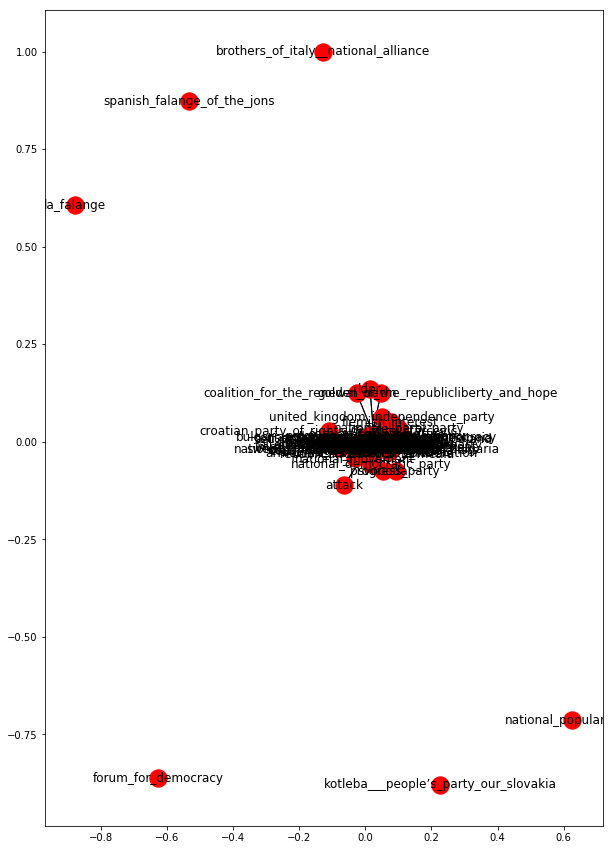

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(10, 15))
nx.draw_networkx(graph, with_labels=True)